In [1]:
import torch
import doubleauction

In [2]:
from doubleauction.util import OrnsteinUhlenbeckProcess

In [3]:
import matplotlib.pyplot as plt
theta = 0.7
sigma = 15.
p = OrnsteinUhlenbeckProcess(theta=theta, sigma = sigma)
sigma * sigma / 2 / theta

160.71428571428572

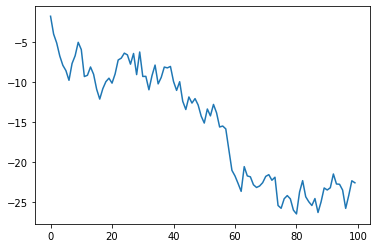

In [4]:
l = []
for i in range(100):
    l.append(p.sample())
    
plt.plot(l)

# Create environment

In [5]:
import matplotlib.pyplot as plt

In [6]:
import doubleauction
from doubleauction.agents import RandomSeller, RandomBuyer, DDPGSellerOU
from doubleauction.environments import MarketEnvironment

from doubleauction.matchers import RandomMatcher

from doubleauction.util import SequentialMemory, hard_update, soft_update
from doubleauction.util import generate_seller_prices_paper, generate_buyer_prices_paper

In [7]:
records = {}
records['rewards'] = []
records['demands'] = []
records['prices'] = []

In [8]:
rewards = []
epochs = 500
warmup_epochs = 20
seller_agent = DDPGSellerOU('learner', 0, 
                                ou_theta=.7, ou_mu=.0, ou_sigma=15., sigma_min=3.5, anneal_steps=300*10*10,
                                  discount = 0.97, lr = 3e-4, 
                                  wd = 1e-4, mem_size=500000, tau=5e-3)

# Run the training algorithm

In [9]:
mdict = torch.load('results/models2')
seller_agent.actor.load_state_dict(mdict['actor'])
seller_agent.actor_target.load_state_dict(mdict['actor_target'])

seller_agent.critic.load_state_dict(mdict['critic'])
seller_agent.critic_target.load_state_dict(mdict['critic_target'])

<All keys matched successfully>

In [10]:
%%time
for e in range(epochs):
    seller_agent.reservation_price = generate_seller_prices_paper(1)[0]
    
    sellers = []
    for ii, p in enumerate(generate_seller_prices_paper(19)):
        sellers.append(RandomSeller('s'+str(ii), p))
    sellers.append(seller_agent)

    buyers = []
    for ii, p in enumerate(generate_buyer_prices_paper(20)):
        buyers.append(RandomBuyer('b'+str(ii), p))

    agents = sellers + buyers
    
    seller_agent.new_game()
    
#     setting = {
#         'self_last_offer': False,
#         'same_side_last_offers': False,
#         'other_side_last_offers': False,
#         'completed_deals': False,
#         'current_time': False,
#         'max_time': False,
#         'n_sellers': False,
#         'n_buyers': False
#     }
    
    ROUNDS_PER_GAME = 10

    market_env = MarketEnvironment(sellers=sellers, buyers=buyers, max_time=10, ## not the same as rounds per game!!
                                   matcher=RandomMatcher(reward_on_reference=True))
    init_observation = market_env.reset()

    round_avg = 0.
    offer_avg = 0.
    time_avg = 0.
    
    records['demands'].append([])
    records['rewards'].append([])
    records['prices'].append(seller_agent.reservation_price)

    for n_round in range(10):
        
        init_observation = market_env.reset()
        observations = {k.agent_id:None for k in agents}
        done = {k.agent_id:False for k in agents}
        reward_hist = []
        rounds = 0
        terminate_round = False
        
        seller_agent.new_round()
        
        records['demands'][-1].append([])
        records['rewards'][-1].append([])
        
        offers_list = []
        
        while not terminate_round:
            offers = {}

            for iagent in agents:
                iagent.receive_observations_from_environment(market_env)
                
            offers = {a.agent_id : a.decide() for a in agents}

            market_env.step(offers)
            
            rewards = market_env.rewards
            
            reward_hist.append(rewards)
            rounds += 1

            terminate_round = market_env.if_round_done or \
                                market_env.agents[market_env.agents['id'] == 'learner']['done'].iloc[0]

            # create record of experience
            seller_agent.memorize(rewards['learner'], terminate_round)
            
            offers_list.append(offers['learner'] - seller_agent.reservation_price)
            
            records['demands'][-1][-1].append(offers['learner'] - seller_agent.reservation_price)
            records['rewards'][-1][-1].append(rewards['learner'])
            
            round_avg += rewards['learner']

            time_avg += 1
    
        offer_avg += sum(offers_list) / len(offers_list)
#         time_vs_rewards.append(round_avg)
#         time_vs_demand.append(sum(offers_list) / len(offers_list))
        
        if e >= warmup_epochs:
            seller_agent.learn()
    
    print('Epoch: {}, Avg. earnings: {}, Avg. demand: {}, Avg. time: {}'.format(e, round_avg / 10., 
                                                                            offer_avg / 10.,
                                                                            time_avg / 10.))
    
    if (e + 1) % 100 == 0:
        torch.save({'actor':seller_agent.actor.state_dict(),
                   'actor_target':seller_agent.actor_target.state_dict(),
                  'critic':seller_agent.critic.state_dict(),
                  'critic_target':seller_agent.critic_target.state_dict()}, 'results/models_ou1_e{}'.format(e))


Epoch: 0, Avg. earnings: -1.2196001464894337, Avg. demand: [-1.21960015], Avg. time: 1.0
Epoch: 1, Avg. earnings: 3.7798910868674356, Avg. demand: [3.79913779], Avg. time: 1.9
Epoch: 2, Avg. earnings: -1.8144431054571044, Avg. demand: [-1.81444311], Avg. time: 1.0
Epoch: 3, Avg. earnings: -6.0143980446573435, Avg. demand: [-6.01439804], Avg. time: 1.0
Epoch: 4, Avg. earnings: -5.969089128926273, Avg. demand: [-5.96908913], Avg. time: 1.0
Epoch: 5, Avg. earnings: -6.760129369568423, Avg. demand: [-6.71679132], Avg. time: 1.1
Epoch: 6, Avg. earnings: -6.898816090063957, Avg. demand: [-6.60442109], Avg. time: 2.6
Epoch: 7, Avg. earnings: -2.1679544853398127, Avg. demand: [-2.16795449], Avg. time: 1.0
Epoch: 8, Avg. earnings: -0.3442985911831542, Avg. demand: [7.3114102], Avg. time: 9.2
Epoch: 9, Avg. earnings: -6.838912107093454, Avg. demand: [-6.83891211], Avg. time: 1.0
Epoch: 10, Avg. earnings: -2.238278443433394, Avg. demand: [-2.23827844], Avg. time: 1.0
Epoch: 11, Avg. earnings: -6.

KeyboardInterrupt: 

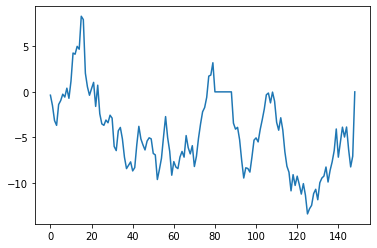

In [11]:
flatten = lambda l: [item for sublist in l for item in sublist]

l2 = flatten( records['rewards'] )
l3 = [sum(ll) for ll in l2]

plt.figure()
plt.plot(l3)
# plt.plot(smooth(l2, 10))

In [12]:
torch.save(records, 'results/records_ou1')

torch.save({'actor':seller_agent.actor.state_dict(),
           'actor_target':seller_agent.actor_target.state_dict(),
          'critic':seller_agent.critic.state_dict(),
          'critic_target':seller_agent.critic_target.state_dict()}, 'results/models_ou1')

In [13]:
torch.save(seller_agent.memory, 'results/memory_ou1')